# NLP Article Processing Pipeline

*Installation and dependencies*

In [1]:
!pip install requests beautifulsoup4 lxml spacy
!python -m spacy download en_core_web_trf
!pip install transformers
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install requests beautifulsoup4 lxml spacy
!python -m spacy download en_core_web_sm
!pip install hf_xet
!pip install wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.9/237.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.6/735.6 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



---


*Imports and configuration*


---



In [2]:
import requests
from bs4 import BeautifulSoup
import spacy
from functools import lru_cache
import os
import re
from transformers import pipeline # For zero-shot, summarization, text2text-generation, and NER
from datetime import datetime, timedelta
import random
from google.colab import userdata
import networkx as nx
import matplotlib.pyplot as plt



---


*Load spaCy Model and further configuration steps*


---



In [3]:
# --- Word Cloud & Display Imports (MODIFIED) ---
try:
    from wordcloud import WordCloud, STOPWORDS as WC_STOPWORDS
    import matplotlib.pyplot as plt
    WORDCLOUD_AVAILABLE = True
    print("WordCloud and Matplotlib loaded successfully.")
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("Warning: The 'wordcloud' or 'matplotlib' library is not installed. Word cloud generation and display will be unavailable.")
    print("You can install them by running: pip install wordcloud matplotlib")

try:
    from PIL import Image
    PIL_AVAILABLE = True
    print("Pillow (PIL) library loaded successfully.")
except ImportError:
    PIL_AVAILABLE = False
    # This warning is now primarily relevant if the user tries to use masking.
    # print("Warning: Pillow (PIL) library not found. Word cloud masking will not be available if attempted.")
    # print("You can install it by running: pip install Pillow")

try:
    import numpy as np
    NUMPY_AVAILABLE = True
    print("NumPy library loaded successfully.")
except ImportError:
    NUMPY_AVAILABLE = False
    # This warning is primarily relevant if the user tries to use masking.
    # print("Warning: NumPy library not found. Word cloud masking might not work as expected if attempted.")
    # print("You can install it by running: pip install numpy")


# --- Configuration ---
SPACY_MODEL_TO_LOAD = "en_core_web_trf"
REQUEST_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
OUTPUT_DIR = "processed_articles"

# --- 1. Load English spaCy model ---
nlp_en = None
try:
    nlp_en = spacy.load(SPACY_MODEL_TO_LOAD, disable=["parser", "ner"])
    nlp_en.add_pipe("sentencizer")
    print(f"English spaCy model ({SPACY_MODEL_TO_LOAD}) loaded successfully.")
except OSError:
    print(f"ERROR: English spaCy model ({SPACY_MODEL_TO_LOAD}) not installed. Please install it with the command:")
    print(f"python -m spacy download {SPACY_MODEL_TO_LOAD}")
    print("The program will exit as the model is not installed.")
    exit()

# --- 2. Load Hugging Face Pipelines ---
zero_shot_classifier = None
summarizer_pipeline = None
title_generator_pipeline = None
ner_pipeline = None

try:
    print("Loading Zero-shot classification pipeline...")
    zero_shot_classifier = pipeline("zero-shot-classification",model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli")
    print("Zero-shot classification pipeline loaded successfully.")
except Exception as e:
    print(f"ERROR: Failed to load the zero-shot classification pipeline: {e}")
    print("Categorization will not be available.")

try:
    print("Loading Summarization pipeline...")
    summarizer_pipeline = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")
    print("Summarization pipeline loaded successfully.")
except Exception as e:
    print(f"ERROR: Failed to load the summarization pipeline: {e}")
    print("Summarization will not be available.")

try:
    print("Loading Text-to-Text Generation pipeline for titles...")
    title_generator_pipeline = pipeline("text2text-generation", model="t5-large")
    print("Text-to-Text Generation pipeline (for titles using t5-large) loaded successfully.")
except Exception as e:
    print(f"ERROR: Failed to load the Text-to-Text Generation pipeline (t5-large): {e}")
    print("Title generation will not be available.")

try:
    print("Loading NER pipeline (dslim/bert-base-NER)...")
    ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", tokenizer="dslim/bert-base-NER", aggregation_strategy="simple")
    print("NER pipeline (dslim/bert-base-NER) loaded successfully.")
except Exception as e:
    print(f"ERROR: Failed to load the NER pipeline (dslim/bert-base-NER): {e}")
    print("Named Entity Recognition will not be available.")

try:
    print("Loading Relations pipeline...")
    relation_pipeline = pipeline("text2text-generation", model="Babelscape/rebel-large")
    print("Relations pipeline loaded successfully.")
except Exception as e:
    print(f"ERROR: Failed to load the Relations pipeline (Babelscape/rebel-large): {e}")
    print("Relations will not be available.")

# Initial checks for loaded models/libraries
if not nlp_en: print("Warning: spaCy model did not load. Tokenization/lemmatization will be skipped.")
if not zero_shot_classifier: print("Warning: Zero-shot classification pipeline did not load.")
# ... other checks ...
if not WORDCLOUD_AVAILABLE: print("Warning: WordCloud/Matplotlib not available. Word cloud functionality limited.")
if PIL_AVAILABLE == False : print("Warning: Pillow (PIL) library not loaded. Word cloud masking will be unavailable.") # More direct warning
if NUMPY_AVAILABLE == False : print("Warning: NumPy library not loaded. Word cloud masking may be affected.") # More direct warning


WordCloud and Matplotlib loaded successfully.
Pillow (PIL) library loaded successfully.
NumPy library loaded successfully.
English spaCy model (en_core_web_trf) loaded successfully.
Loading Zero-shot classification pipeline...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


Zero-shot classification pipeline loaded successfully.
Loading Summarization pipeline...


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0


Summarization pipeline loaded successfully.
Loading Text-to-Text Generation pipeline for titles...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


Text-to-Text Generation pipeline (for titles using t5-large) loaded successfully.
Loading NER pipeline (dslim/bert-base-NER)...


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


NER pipeline (dslim/bert-base-NER) loaded successfully.
Loading Relations pipeline...


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

Device set to use cuda:0


Relations pipeline loaded successfully.




---


*1. Fetching the HTML data + 2. Extract Text & Initial Clean (HTML-től való tisztítás, majd tartalmi zaj szűrése)*


---



In [39]:
# --- HTML Helper Functions ---
def fetch_html_content(url):
    """Fetches HTML content from the given URL."""
    try:
        if "news.google.com/read" in url:
            print(f"Warning: The URL '{url}' appears to be a Google News redirector. ")
            print("Attempting to fetch, but the content might be from the redirect page, not the final article.")
            print("For best results, try to use the direct article URL.")
        response = requests.get(url, headers=REQUEST_HEADERS, timeout=20, allow_redirects=True)
        response.raise_for_status()
        response.encoding = response.apparent_encoding if response.apparent_encoding else 'utf-8'
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while fetching URL '{url}': {e}")
        return None

def extract_text_from_html(html_string, main_content_selectors=None, selectors_to_exclude=None):
    """Extracts clean text from an HTML string."""
    if not html_string: return ""
    soup = BeautifulSoup(html_string, 'lxml')
    for element in soup(["script", "style"]): element.decompose()
    content_scope = soup
    if main_content_selectors:
        for selector in main_content_selectors:
            selected_block = soup.select_one(selector)
            if selected_block: content_scope = selected_block; break
    if selectors_to_exclude and content_scope:
        for selector in selectors_to_exclude:
            for element_to_remove in content_scope.select(selector): element_to_remove.decompose()
    if content_scope == soup:
        common_boilerplate_tags = ["header", "footer", "nav", "aside", "form", "figure", "figcaption"]
        for tag_name in common_boilerplate_tags:
            for tag in content_scope.find_all(tag_name): tag.decompose()
    text = content_scope.get_text(separator=' ', strip=True) if content_scope else ""
    return ' '.join(text.split())

 # --- File Handling Function ---
def save_text_to_file(text_content, filepath):
    try:
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with open(filepath, "w", encoding="utf-8") as f: f.write(text_content)
        print(f"   File saved successfully: {filepath}")
    except IOError as e: print(f"   Error writing file ({filepath}): {e}")

def generate_safe_filename(url_or_title, suffix=""):
    if not url_or_title: base_name = f"article_{suffix}"
    else:
        name_part = url_or_title.split('/')[-1] if '/' in url_or_title else url_or_title
        name_part = name_part.split('?')[0]
        safe_name = re.sub(r'[^a-zA-Z0-9_-]+', '_', name_part).strip('_')[:50]
        base_name = f"{safe_name}_{suffix}" if safe_name else f"article_{suffix}"
    # Default to .txt, will be changed for .png by the caller
    return os.path.join(OUTPUT_DIR, f"{base_name}.txt" if not suffix.endswith((".png", ".jpg")) else base_name)

# --- Text Cleaning Function ---
def clean_common_boilerplate_phrases(text):
    unwanted_phrases = [
        "IE 11 is not supported.",
        "Internet Explorer is not supported.",
        "To continue using our site, please enable JavaScript in your browser settings.",
        "Please enable JavaScript to view the comments powered by Disqus.",
        "This website uses cookies to ensure you get the best experience on our website.",
        "We use cookies to enhance your Browse experience.",
        "By continuing to use this site you consent to the use of cookies.",
        "Log in to leave a comment.",
        "Sign up for our newsletter.",
        "Follow us on Facebook.", # és más közösségi média felhívások
        "Advertisement",
        "Read more:",
        "Related stories:",
        "Source:",
        "Photo by:",
        "Image credit:",
        "Click here to",
        # Esetleg dátum/idő formátumok, amik nem a cikk részei, de a scraper összeszedi
        # Rövid, értelmetlen sorok, amik pl. menüpontok maradékai lehetnek
        r"\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b", # Pl. "15 May"
        r"Copyright © \d{4}", # Pl. "Copyright © 2025"
        r"All rights reserved\.",
        # További, általad tapasztalt zavaró elemek
    ]

    # Egyszerű szövegcserék
    for phrase in unwanted_phrases:
        # Használhatsz re.IGNORECASE-t is, ha a kis/nagybetű nem számít
        text = re.sub(re.escape(phrase), "", text, flags=re.IGNORECASE)

    # Specifikusabb reguláris kifejezések (példa)
    # Pl. "XYZ is not supported" általánosítása:
    text = re.sub(r"[a-zA-Z0-9\s]+ is not supported\.?", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Please enable JavaScript.*?\.", "", text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r"This site uses cookies.*?\.", "", text, flags=re.IGNORECASE | re.DOTALL)


    # Felesleges szóközök eltávolítása, amik a cserék után maradtak
    text = ' '.join(text.split())
    return text


In [40]:
# --- Main Processing Function ---
def process_article_url(article_url, main_content_selectors=None, selectors_to_exclude=None):
    if not nlp_en: print("spaCy model not available...")

    print(f"Processing started: {article_url}")
    if not os.path.exists(OUTPUT_DIR):
        try: os.makedirs(OUTPUT_DIR); print(f"Output directory created: {OUTPUT_DIR}")
        except OSError as e: print(f"Error creating output directory ({OUTPUT_DIR}): {e}"); return

    print(f"\n1. Fetching HTML content...")
    html_code = fetch_html_content(article_url)
    if not html_code: print("   Failed to download HTML. Processing stopped."); return

    # 2. Extract Text & Initial Clean (HTML-től való tisztítás, majd tartalmi zaj szűrése)
    print("\n2. Extracting and cleaning text from HTML...")
    # Először kinyerjük a szöveget a HTML-ből
    raw_extracted_text = extract_text_from_html(html_code, main_content_selectors, selectors_to_exclude)

    if not raw_extracted_text: # Ellenőrizzük, sikerült-e szöveget kinyerni
        print("   Failed to extract any text from HTML. Processing stopped.")
        return

    # Opcionális: Itt elmentheted a teljesen "nyers", csak HTML-től tisztított szöveget, ha szükséged van rá diagnosztikához
    # print(f"   Raw extracted text (before boilerplate phrase cleaning, first 200 chars): '{raw_extracted_text[:200]}...'")
    # save_text_to_file(raw_extracted_text, generate_safe_filename(article_url, "raw_extracted.txt"))

    # Most alkalmazzuk a tartalmi zajszűrőt (pl. "IE 11 is not supported" és hasonlók eltávolítása)
    print("   Applying general boilerplate phrase cleaning...")
    raw_cleaned_text = clean_common_boilerplate_phrases(raw_extracted_text) # Itt használjuk a korábban definiált függvényt

    if not raw_cleaned_text: # Ellenőrizzük, hogy a tisztítás után maradt-e értelmes szöveg
        print("   Text became empty after boilerplate phrase cleaning. Processing stopped.")
        return

    # Kiírjuk és elmentjük a véglegesen megtisztított szöveget, amit a további NLP lépésekhez használunk
    print(f"   Final cleaned text (first 300 chars): '{raw_cleaned_text[:300]}...'")
    save_text_to_file(raw_cleaned_text, generate_safe_filename(article_url, "cleaned_text.txt")) # A fájlnév itt már "cleaned_text.txt"

    # A címkefelhőhöz használt szöveg előkészítése:
    # Alapértelmezetten a (tartalmi zajtól is) megtisztított nyers szöveget használjuk.
    # Ezt később felülírjuk a lemmatizált szöveggel, ha a lemmatizálás sikeres.
    text_for_cloud = raw_cleaned_text
    lemmatized_text_string = None # Ezt a változót a lemmatizálási lépésben töltjük fel, ha sikeres

    return raw_cleaned_text, article_url, text_for_cloud, lemmatized_text_string


*p.s. please do not forget to create your NEWS_API_KEY in the Google Colab Secret!*


In [42]:
def fetch_random_popular_article():
    """
    Fetches one random article from the most popular news items
    published in the past 7 days using the NewsAPI. The LLM will categorize
    this.

    :return: A dictionary with the selected article's data.
    :rtype: dict
    :raises ValueError: If the API key is missing.
    :raises Exception: If the API request fails.
    """
    API_KEY = userdata.get('NEWS_API_KEY')
    if not API_KEY:
        raise ValueError("ERROR: NEWS_API_KEY is missing from environment variables!")

    base_url = "https://newsapi.org/v2/everything"
    today = datetime.now().date()
    seven_days_ago = today - timedelta(days=7)

    params = {
        "apiKey": API_KEY,
        "q": "world",  # to include every article
        "from": seven_days_ago.isoformat(),
        "to": today.isoformat(),
        "sortBy": "popularity",  # important!
        "language": "en",
        "pageSize": 20
    }

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        raise Exception(f"NewsAPI Error {response.status_code}: {response.text}")

    data = response.json()
    articles = data.get("articles", [])
    if not articles:
        raise Exception("ERROR: No popular articles found in the past 7 days.")

    chosen_article = random.choice(articles)
    return {
        "title": chosen_article["title"],
        "description": chosen_article["description"],
        "url": chosen_article["url"],
        "publishedAt": chosen_article["publishedAt"],
        "source": chosen_article["source"]["name"]
    }


In [45]:
random_chosen_article = fetch_random_popular_article()

# A fetch_and_clean_article függvény hívása
url_to_process = random_chosen_article["url"]
processing_results = process_article_url(url_to_process)
if processing_results is not None:
    raw_cleaned_text, article_url, text_for_cloud, lemmatized_text_string = processing_results

if raw_cleaned_text:
    print(f"\nSuccessfully fetched and cleaned text from {article_url}")
else:
    print("\nArticle processing failed at the fetch and clean stage.")
    raw_cleaned_text = None
    article_url = None
    text_for_cloud = None
    lemmatized_text_string = None


Processing started: https://www.theverge.com/news/675058/tesla-europe-april-sales-musk-doge-brand-crisis

1. Fetching HTML content...

2. Extracting and cleaning text from HTML...
   Applying general boilerplate phrase cleaning...
   Final cleaned text (first 300 chars): 'Tesla continues to circle the drain | The Verge Skip to main content The homepage The Verge The Verge logo. The homepage The Verge The Verge logo. Menu Expand Navigation Drawer The Verge The Verge logo. Login / Sign Up close Close Subscribe Facebook Threads Instagram Youtube RSS Comments Drawer News...'
   File saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_cleaned_text.txt.txt

Successfully fetched and cleaned text from https://www.theverge.com/news/675058/tesla-europe-april-sales-musk-doge-brand-crisis




---


*3. Tokenization + 4. Lemmanizations*


---



In [46]:
# ---Helper Functions ---
# --- NLP Processing Functions ---
@lru_cache(maxsize=128)
def get_tokenized_text_spacy(text_to_process):
    if not nlp_en or not text_to_process: return ""
    doc = nlp_en(text_to_process)
    return " ".join([token.text for token in doc if not token.is_space])


@lru_cache(maxsize=128)
def get_lemmatized_text_spacy(text_to_process):
    if not nlp_en or not text_to_process: return [], ""
    doc = nlp_en(text_to_process)
    lemmas = []
    for token in doc:
        if not token.is_punct and not token.is_space and len(token.lemma_) > 0:
            lemma_to_add = token.lemma_.lower()
            if token.pos_ == "PRON" and token.lemma_ == "-PRON-": lemma_to_add = token.text.lower()
            if lemma_to_add and (token.is_alpha or token.like_num): lemmas.append(lemma_to_add)
    return lemmas, " ".join(lemmas)


In [47]:
if nlp_en:
    print("\n3. Tokenizing text with spaCy...")
    tokenized_text = get_tokenized_text_spacy(raw_cleaned_text)
    if tokenized_text: save_text_to_file(tokenized_text, generate_safe_filename(article_url, "tokenized_specific"))
    else: print("   Failed to tokenize text.")

    print("\n4. Lemmatizing text with spaCy...")
    _, lemmatized_text_string = get_lemmatized_text_spacy(raw_cleaned_text)
    if lemmatized_text_string:
        lemmatized_text_string_for_cloud = lemmatized_text_string
        save_text_to_file(lemmatized_text_string, generate_safe_filename(article_url, "lemmatized_specific"))
    else: print("   Failed to lemmatize text.")
else:
    print("\nWarning: spaCy model not loaded, skipping tokenization and lemmatization. Using raw text for word cloud.")


3. Tokenizing text with spaCy...
   File saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_tokenized_specific.txt

4. Lemmatizing text with spaCy...
   File saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_lemmatized_specific.txt




---


*5. Generation of the Word Cloud*


---



In [48]:
# --- Word Cloud Generation Function (MODIFIED) ---
def generate_and_save_wordcloud(text_for_cloud, filepath,
                                width=1200, height=600, background_color='white',
                                custom_stopwords=None,
                                display_cloud=False,
                                mask_image_path=None,
                                colormap_wc='viridis', # Default Matplotlib colormap
                                font_path_wc=None,
                                contour_width_wc=0,
                                contour_color_wc='black'):
    """
    Generates a word cloud, saves it, and optionally displays it.
    """
    if not WORDCLOUD_AVAILABLE:
        print("   Skipping word cloud: 'wordcloud' or 'matplotlib' library not available.")
        return False
    if not text_for_cloud or not text_for_cloud.strip():
        print("   Warning: No meaningful text provided for word cloud generation.")
        return False

    mask_array = None
    if mask_image_path:
        if PIL_AVAILABLE and NUMPY_AVAILABLE:
            try:
                mask_image = Image.open(mask_image_path).convert("RGBA") # Ensure alpha for transparent parts
                mask_array = np.array(mask_image)
                # For typical masks, white areas should be transparent.
                # WordCloud expects 0 for transparent in the mask array if it's binary.
                # If the mask is an alpha channel, 0 means transparent.
                # If it's a shape on white background, we might need to process it
                # so the shape is non-zero and background is zero.
                # Assuming mask_array has shape as non-zero and background as zero or transparent.
                print(f"   Using mask image: {mask_image_path}")
            except FileNotFoundError:
                print(f"   ERROR: Mask image not found at '{mask_image_path}'. Proceeding without mask.")
            except Exception as e:
                print(f"   ERROR: Could not load or process mask image: {e}. Proceeding without mask.")
        else:
            print("   Warning: Pillow or NumPy not available. Cannot use mask image.")
            if not PIL_AVAILABLE: print("   (Pillow is missing)")
            if not NUMPY_AVAILABLE: print("   (NumPy is missing)")


    stopwords_set = WC_STOPWORDS.copy()
    if custom_stopwords:
        stopwords_set.update(custom_stopwords)
    additional_common_words = {
        "ref", "fig", "figure", "table", "image", "photo", "chart", "advertisement",
        "subscribe", "login", "text", "content", "article", "page", "view", "read", "more",
        "say", "said", "also", "would", "could", "should", "told", "new", "like", "one", "two", "time"
    } # Added more common words
    stopwords_set.update(additional_common_words)

    try:
        wc_params = {
            'width': width,
            'height': height,
            'background_color': background_color,
            'stopwords': stopwords_set,
            'min_font_size': 10,
            'collocations': False,
            'prefer_horizontal': 0.95, # Slightly more horizontal
            'max_words': 200, # Increased max_words
            'mask': mask_array,
            'font_path': font_path_wc,
            'colormap': colormap_wc,
            'contour_width': contour_width_wc if mask_array is not None else 0,
            'contour_color': contour_color_wc if mask_array is not None else background_color,
        }
        # Filter out None parameters that WordCloud might not handle well if explicitly set to None
        # (though 'mask' and 'font_path' are usually fine with None)
        final_wc_params = {k: v for k, v in wc_params.items() if k == 'mask' or v is not None}


        wordcloud_generator = WordCloud(**final_wc_params).generate(text_for_cloud)

        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        wordcloud_generator.to_file(filepath)
        print(f"   Word cloud saved successfully: {filepath}")

        if display_cloud:
            plt.figure(figsize=(max(10, int(width/100)), max(5, int(height/100)))) # Dynamic figure size
            plt.imshow(wordcloud_generator, interpolation='bilinear')
            plt.axis("off")
            plt.tight_layout(pad=0) # Remove padding for a cleaner look
            plt.show() # This will block execution until the window is closed
            print("   Word cloud displayed (close the window to continue).")
        return True

    except Exception as e:
        print(f"   Error occurred during word cloud generation or display: {e}")
        return False



5. Generating Word Cloud...
   Attempting to generate word cloud with display: True, mask: None, colormap: None
   Word cloud saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_wordcloud_specific.png


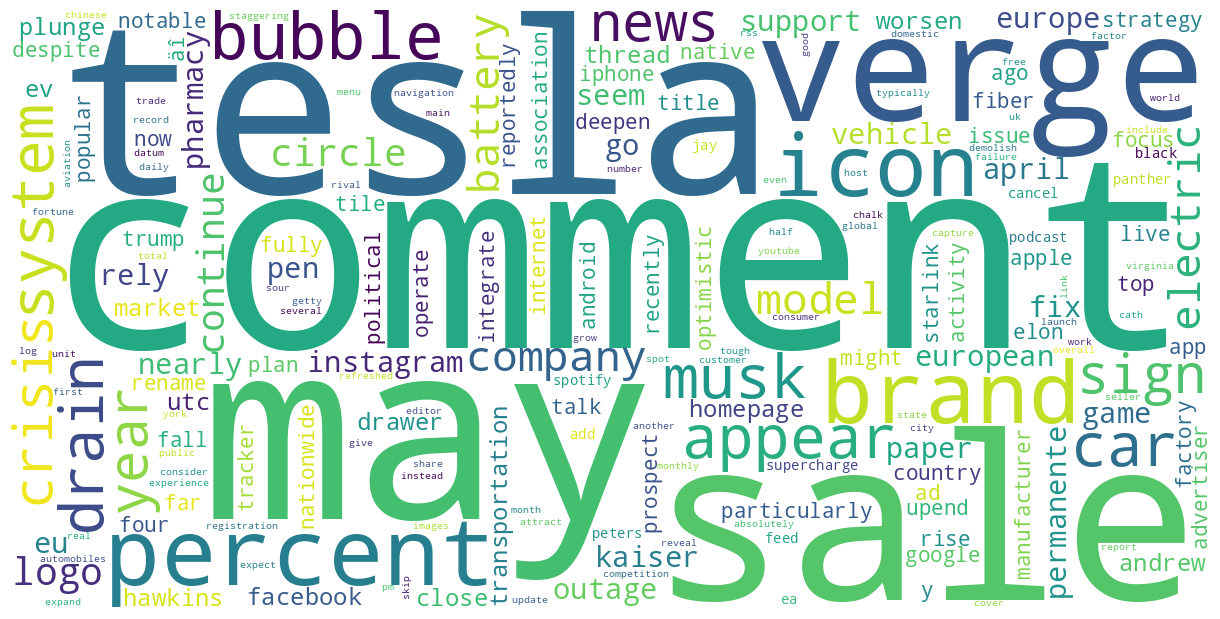

   Word cloud displayed (close the window to continue).
   Word cloud generation process completed.


In [49]:
# --- 5. Generate and Save Word Cloud (MODIFIED STEP) ---
print("\n5. Generating Word Cloud...")
if WORDCLOUD_AVAILABLE:
    if lemmatized_text_string_for_cloud:
        # Ensure the suffix for the image file is correct
        base_fn_wc = generate_safe_filename(article_url, "wordcloud_specific").replace(".txt", "")
        wordcloud_output_filepath = f"{base_fn_wc}.png"

        # --- Word Cloud Customization Options (Examples) ---
        # Set to True to display the cloud in a window
        display_option = True # VÁLTOZTASD MEG True-ra A MEGJELENÍTÉSHEZ

        # Maszk kép elérési útja (cseréld ki a sajátodra, vagy hagyd None-on)
        # Készíts egy PNG képet (pl. egy alakzat sziluettjét).
        # A fehér (#FFFFFF) részek lesznek átlátszóak; más színek adják az alakzatot.
        # example_mask_path = "mask_images/twitter_mask.png" # Példa elérési út
        example_mask_path = None # Hagyd None-on, ha nem akarsz maszkot

        # Színséma (valassz a matplotlib colormap-ek közül, vagy hagyd az alapértelmezettet)
        # Példák: 'viridis', 'plasma', 'magma', 'inferno', 'cividis', 'Blues', 'Reds', 'ocean', 'terrain'
        # chosen_colormap = 'ocean'
        chosen_colormap = None # None esetén a WordCloud alapértelmezett színeit használja (ami általában változatos)

        # Egyedi betűtípus elérési útja (.ttf vagy .otf)
        # example_font_path = "fonts/Roboto-Regular.ttf" # Példa elérési út
        example_font_path = None # Hagyd None-on az alapértelmezett betűtípushoz

        # Kontúr maszkolt képhez (ha használsz maszkot)
        contour_w = 1 if example_mask_path else 0
        contour_c = 'grey'

        print(f"   Attempting to generate word cloud with display: {display_option}, mask: {example_mask_path}, colormap: {chosen_colormap}")

        if generate_and_save_wordcloud(lemmatized_text_string_for_cloud,
                                        wordcloud_output_filepath,
                                        display_cloud=display_option,
                                        mask_image_path=example_mask_path,
                                        colormap_wc=chosen_colormap,
                                        font_path_wc=example_font_path,
                                        contour_width_wc=contour_w,
                                        contour_color_wc=contour_c,
                                        background_color='white' # Lehet 'black' is pl. sötét témához
                                        ):
            print(f"   Word cloud generation process completed.")
        else:
            print("   Word cloud generation failed or was skipped due to issues.")
    else:
        print("   No text available for word cloud generation.")
else:
    print("   Word cloud generation skipped because 'wordcloud' library is not available.")





---


*6. Generating text summary*


---



In [50]:
# --- Helper Functions ---
def generate_summary_abstractive(text_to_summarize, summarizer):
    if not summarizer: print("Warning: Summarizer not loaded..."); return None
    if not text_to_summarize: print("Warning: No text for summarization."); return None
    try:
        summary = summarizer(text_to_summarize[:4000], max_length=150, min_length=40, do_sample=False)
        if summary and isinstance(summary, list) and summary[0] and 'summary_text' in summary[0]: return summary[0]['summary_text']
        print("Warning: Summarizer output format unexpected."); return None
    except Exception as e: print(f"Error in summarization: {e}"); return None


In [51]:
print("\n6. Generating text summary...")
if raw_cleaned_text and summarizer_pipeline:
  article_summary = generate_summary_abstractive(raw_cleaned_text, summarizer_pipeline)
  if article_summary:
    print(f"   Generated summary: {article_summary}")
    save_text_to_file(article_summary, generate_safe_filename(article_url, "summary_specific"))
  else: print("   Failed to generate summary.")
# ...

# Adjust subsequent step numbers if necessary (they seem fine as they are)



6. Generating text summary...
   Generated summary:  The company‚Äôs sales in Europe plunged by nearly 50 percent in April year over year . Tesla only logged 7,261 new vehicle registrations in April, nearly half of what it recorded in April 2024 . The numbers are particularly notable considering Tesla recently launched the refreshed Model Y, an update on the global best-seller .
   File saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_summary_specific.txt




---


*7. Categorizing text (zero-shot)*


---



In [52]:
# --- Helper Functions ---
# --- Categorization, Summarization, Title Generation, NER (EXISTING FUNCTIONS UNCHANGED) ---
def categorize_text_zero_shot(text_to_categorize, categories, classifier_pipeline):
    if not classifier_pipeline: print("Warning: Zero-shot classifier not loaded..."); return None
    if not text_to_categorize or not categories: print("Warning: No text or categories for categorization."); return None
    try:
        return classifier_pipeline(text_to_categorize[:2048], candidate_labels=categories, multi_label=False)
    except Exception as e: print(f"Error in categorization: {e}"); return None


In [53]:
print("\n7. Categorizing text (zero-shot)...")
# ... (rest of the processing steps: Categorization, Summarization, Title, NER) ...
if raw_cleaned_text and zero_shot_classifier:
    # ... (categorization code)
    candidate_article_categories = [
        "sport", "football", "politics", "business", "finance", "technology", "science",
        "health", "medicine", "education", "music", "movie","world news", "culture", "art", "travel", "food", "lifestyle", "environment",
        "social issues", "mental health", "entertainment"
    ]
    category_results = categorize_text_zero_shot(article_summary, candidate_article_categories, zero_shot_classifier)
    if category_results and category_results['labels'] and category_results['scores']:
        print(f"   Predicted category: {category_results['labels'][0]} (Score: {category_results['scores'][0]:.4f})")
    else: print("   Could not determine a clear category.")
# ...



7. Categorizing text (zero-shot)...
   Predicted category: technology (Score: 0.6728)




---


*8. Generating title*


---



In [54]:
# --- Helper Functions ---
def generate_title_t5(text_to_get_title_from, title_generator, max_input_chars=2048):
    if not title_generator: print("Warning: Title generator not loaded..."); return None
    if not text_to_get_title_from: print("Warning: No text for title generation."); return None
    try:
        title_result = title_generator("generate headline: " + text_to_get_title_from[:max_input_chars], max_length=30, min_length=5, num_beams=4, early_stopping=True)
        if title_result and isinstance(title_result, list) and title_result[0] and 'generated_text' in title_result[0]: return title_result[0]['generated_text']
        print("Warning: Title generator output format unexpected."); return None
    except Exception as e: print(f"Error in title generation: {e}"); return None


In [55]:
print("\n8. Generating title...")
if raw_cleaned_text and title_generator_pipeline:
    generated_raw_title = generate_title_t5(article_summary, title_generator_pipeline)
    if generated_raw_title:
        processed_title = generated_raw_title.strip()
        # Further processing if needed (e.g., taking first sentence, capitalizing)
        first_period = processed_title.find('.')
        if first_period != -1: processed_title = processed_title[:first_period+1]
        if processed_title: processed_title = processed_title[0].upper() + processed_title[1:]
        print(f"   Generated title: {processed_title}")
        save_text_to_file(processed_title, generate_safe_filename(article_url, "title_specific"))
    else: print("   Failed to generate title.")
# ...


Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



8. Generating title...
   Generated title: Tesla only logged 7,261 new vehicle registrations in April, nearly half of what it recorded in April 2024 .
   File saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_title_specific.txt




---


*9. Extracting Named Entities (BERT with Post-processing)*


---



In [56]:
# --- Helper functions ---
def post_process_ner_entities(raw_entities_list, score_threshold=0.70):
    if not raw_entities_list: return []
    processed = [e for e in raw_entities_list if e['score'] >= score_threshold]
    # Basic merging (simplified)
    merged = []
    i = 0
    while i < len(processed):
        current = processed[i]
        if current['text'].startswith("##") and merged and merged[-1]['type'] == current['type'] and not merged[-1]['text'].endswith(" "):
            merged[-1]['text'] += current['text'].replace("##", "")
            merged[-1]['score'] = (merged[-1]['score'] + current['score']) / 2
        else:
            merged.append(dict(current))
        i += 1
    processed = merged
    # False positive filtering (simplified)
    known_fp = {("Man", "PER"), ("In", "ORG")}
    processed = [e for e in processed if (e['text'], e['type']) not in known_fp and not (len(e['text']) < 3 and e['type'] in ['ORG', 'PER'] and not any(c.isupper() for c in e['text']))]
    # Unique entities
    unique = { (e['text'].strip(), e['type']): e for e in processed }
    final_list = sorted(list(unique.values()), key=lambda x: x['score'], reverse=True)
    return final_list

def extract_named_entities_bert(text_to_process, ner_model_pipeline, max_chars=4000):
    if not ner_model_pipeline: print("Warning: NER pipeline not loaded..."); return None, ""
    if not text_to_process: print("Warning: No text for NER."); return [], ""
    try:
        entities_raw = ner_model_pipeline(text_to_process[:max_chars])
        formatted = [{"text": e['word'], "type": e['entity_group'], "score": float(e['score'])} for e in entities_raw]
        processed_list = post_process_ner_entities(formatted)
        str_output = "\n".join([f"Entity: {e['text']}, Type: {e['type']} (Score: {e['score']:.4f})" for e in processed_list])
        return processed_list, str_output
    except Exception as e: print(f"Error in NER: {e}"); return None, ""


In [57]:
print("\n9. Extracting Named Entities (BERT with Post-processing)...")
if raw_cleaned_text and ner_pipeline:
    processed_entities_list, processed_entities_string = extract_named_entities_bert(raw_cleaned_text, ner_pipeline)
    if processed_entities_list is not None:
        if processed_entities_list:
            print(f"   Extracted {len(processed_entities_list)} entities after post-processing (showing up to 10):")
            for entity in processed_entities_list[:10]: print(f"     - {entity['text']} ({entity['type']}, Score: {entity['score']:.3f})")
            if len(processed_entities_list) > 10: print(f"     ... and {len(processed_entities_list) - 10} more.")
            save_text_to_file(processed_entities_string, generate_safe_filename(article_url, "entities_processed_specific"))
        else: print("   No entities found after post-processing.")
    else: print("   Failed to extract entities or an error occurred.")
# ...



9. Extracting Named Entities (BERT with Post-processing)...
   Extracted 15 entities after post-processing (showing up to 10):
     - Europe (LOC, Score: 1.000)
     - European Free Trade Association (ORG, Score: 0.999)
     - City & State (ORG, Score: 0.999)
     - European Automobiles Manufacturers Association (ORG, Score: 0.998)
     - Hawkins (PER, Score: 0.998)
     - UK (LOC, Score: 0.995)
     - Andrew J. Hawkins (PER, Score: 0.992)
     - The New York Daily News (ORG, Score: 0.986)
     - Getty Images (ORG, Score: 0.981)
     - EU (ORG, Score: 0.970)
     ... and 5 more.
   File saved successfully: processed_articles/tesla-europe-april-sales-musk-doge-brand-crisis_entities_processed_specific.txt


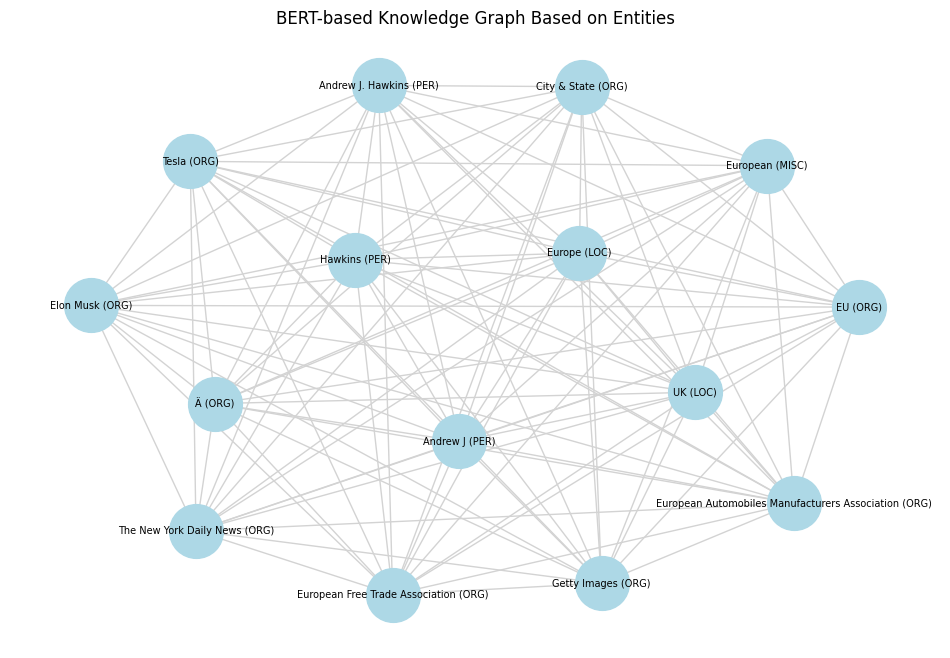

In [83]:
def build_knowledge_graph_from_entities(entities):
    G = nx.Graph()

    # Creating Nodes from Entities
    for ent in entities:
        label = f"{ent['text']} ({ent['type']})"
        G.add_node(label)

    # Simple Relationship Network: Every entity is connected to every other entity
    for i in range(len(entities)):
        for j in range(i+1, len(entities)):
            ent1 = entities[i]
            ent2 = entities[j]
            label1 = f"{ent1['text']} ({ent1['type']})"
            label2 = f"{ent2['text']} ({ent2['type']})"
            G.add_edge(label1, label2)

    return G

def draw_knowledge_graph(G, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.7)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=7)
    plt.title("BERT-based Knowledge Graph Based on Entities")
    plt.axis('off')
    plt.show()

# --- Generating a Knowledge Graph from the Processed Entities ---
if processed_entities_list:
    G = build_knowledge_graph_from_entities(processed_entities_list)
    draw_knowledge_graph(G)
else:
    print("There are not enough entities available for the graph.")

In [59]:
# --- Main execution block ---
# if __name__ == "__main__":

print(f"\nProcessing finished for: {article_url}")

# url_to_process = "https://www.nbcnews.com/health/health-news/cost-weight-loss-drugs-wegovy-zepbound-how-low-prices-down-rcna205911"
# url_to_process = "https://www.reuters.com/world/europe/putin-xi-map-out-new-era-press-conference-after-kremlin-talks-2023-03-21/"
# url_to_process = "https://edition.cnn.com/2024/03/17/tech/spacex-starship-launch-what-next/index.html"

# Csabi teszt:
## url_to_process = "https://www.wired.com/story/jony-ive-open-ai-hardware-io/"

# Hívd meg a feldolgozást az URL-lel (és opcionális szelektorokkal, ha szükséges)
# process_article_url(url_to_process)

# Példa egy másik URL feldolgozására, esetleg eltérő szelektorokkal:
# url_reuters = "https://www.reuters.com/technology/musk-says-xaitests-grok-chatbot-with-more-users-after-political-bias-concerns-2024-03-15/"
# main_selectors_reuters = ['article[data-testid="ArticlePage-article-body"]']
# exclude_selectors_reuters = ['div[data-testid="Paywall-Container"]', 'div[data-testid="AdditionalCoverage-Container"]']
# process_article_url(url_reuters, main_selectors_reuters, exclude_selectors_reuters)


Processing finished for: https://www.theverge.com/news/675058/tesla-europe-april-sales-musk-doge-brand-crisis
